# Virus spreading simulator 

This is simple simulator program for modeling the virus spreading using the actual mechanisms (sneezing) for the virus transfer. 

The simulator models the persons and their common locations (home, work, school, shops). When person is sick, the virus makes the person sneeze, which then transfers the virus to the nearby persons. 

The code is built to support vaccinations and other countermeasure options.

(c) Mikko Kursula, 2020, MIT License. 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time 

from person import Person
from virus import Virus
from event import Home, Work, School, Shop
from visuals import plot_sick_ratio, plot_cumul_inf_ratio
from run_sim import run_sim
from analysis import cumul_inf_ratio

### Setup the simulation scenario

This function puts everything together and defines the simulation scenario. 

In [2]:
def setup_simulation(virus : Virus, 
                     n_home : int = 200,
                     n_work : int = 15,
                     n_school : int = 10,
                     n_shop : int = 3,
                     n_sick : int = 3,
                     n_adults_per_home = [1, 2],
                     n_kids_per_home = [0, 6],
                     vaccinated_ratio : float = 0, 
                     sick_leave_ok_ratio : float = 0, 
                     random_seed : int = 42
                    ) -> tuple:
    """
    Simulation scenario setup. All locations (homes etc.), persons and the initial infections 
    are created here. 
    
    In home, school, work and shop setup the size parameter defines the bounding box for the  
    place and the persons are randomly located inside that box. Larger size means less likely 
    virus transfer. The dimensions are in meters. Virus transfer affects only the persons
    assigned to that location and the virus will not transfer outside of the box. 
    
    People are assigned to homes, schools, workplaces, etc. These are set at the beginning 
    of simulation and those remain constant, i.e. the persons will always return to the 
    same home and will always go to the same workplace. Note that e.g. the larger the number 
    of different workplaces, the less persons there will be per workplace if the number of 
    persons is kept constant. The number of workplaces, schools and shops can be used to 
    test social distancing. 
    
    The schedules of different location/event visits is setup in person event schedule 
    at one hour granularity level. The setup covers one full day of life that repeats as such 
    indefinitely. Only possible change to the scheduling is when person is sick and the
    person is allowed to stay at home when sick, in which case the person stays at 
    home until the disease has healed. 
    
    Each day the kids go to school and adults go to work. Randomly picked adults will 
    also visit at shop. 
    
    The virus setup includes the contagious time window (in hours), time to heal and other 
    basic parameters. 
    
    At the end of this function the initial virus infections are created as a 
    starting condition for the simulation. 
    
    This function returns the person and event instances that can be used to run 
    the simulation. 
    
    Selected parameter explanations: 
    n_home : number of homes. 
    n_work : number of workplaces.
    n_school : number of schools.
    n_shop : number of schools.
    n_sick : number of persons sick at the beginning of simulation.
    n_adults_per_home : [min, max] number of adults per each home.
    n_kids_per_home : [min, max] number of kids per each home.
    vaccinated_ratio : Ratio of persons vaccinated against the virus, min=0, max=1.
    sick_leave_ok_ratio : Ratio of persons allowed to stay home when sick, min=0, max=1.
    """
    np.random.seed(random_seed)

    # Create homes 
    homes = []
    grid_w = 50 
    for idx in range(n_home):
        home = Home(name='h_{}'.format(idx), size=[10, 10])
        homes.append(home)

    # Create workplaces
    workplaces = []
    for idx in range(n_work):
        work = Work(name='work_{}'.format(idx), size=[50, 50])
        workplaces.append(work)
        
    # Create schools
    schools = []
    for idx in range(n_school):
        school = School(name='school_{}'.format(idx), size=[100, 50])
        schools.append(school)

    # Create shops
    shops = []
    for idx in range(n_shop):
        shop = Shop(name='shop_{}'.format(idx), size=[100, 100])
        shops.append(shop)
        
    # Create person instances and assign them to homes and workplaces etc
    persons = []
    adult_counter = 0
    kid_counter = 0

    # Create look-up tables for the number of persons per home. This ensures that the 
    # person distributions stay the same when some other parameters are changed, such 
    # as the number of schools. 
    n_lut = 50
    n_kid_lut = []
    n_adult_lut = []
    for i in range(n_lut):
        n_adult = np.random.randint(n_adults_per_home[1] + 1 - n_adults_per_home[0])
        n_adult += n_adults_per_home[0]
        n_adult_lut.append(n_adult)
        n_kid = np.random.randint(n_kids_per_home[1] + 1 - n_kids_per_home[0])
        n_kid += n_kids_per_home[0]
        n_kid_lut.append(n_kid)
    
    for home in homes: 
        n_adult = n_adult_lut[adult_counter % n_lut]
        for idx in range(n_adult): 
            adult_counter += 1
            age = 18 + np.random.randint(70)
            name = 'adult_{}'.format(adult_counter)
            person = Person(name=name, age=age)

            # Setup home, work and schedules
            person.add_event(event_hours=np.arange(0, 24, 1), event=home)
            
            work = np.random.choice(workplaces)
            work_start = np.random.randint(4) + 6
            work_end = np.random.randint(4) + 14
            work_hours = np.arange(work_start, work_end, 1)
            person.add_event(event_hours=work_hours, event=work)

            if np.random.rand() < 0.3:
                shop = np.random.choice(shops)
                shop_hour = work_end + 1 
                person.add_event(event_hours=[shop_hour], event=shop)
            
            if np.random.rand() < vaccinated_ratio: 
                person.vaccinate()
            
            if np.random.rand() < sick_leave_ok_ratio:
                person.enable_sick_leave()
            
            persons.append(person)
            
        n_kid = n_kid_lut[kid_counter % n_lut]
        kid_counter += 1
        for idx in range(n_kid): 
            kid_counter += 1
            age = np.random.randint(18)
            name = 'kid_{}'.format(kid_counter)
            person = Person(name=name, age=age)

            # Setup home etc schedules
            person.add_event(event_hours=np.arange(0, 24, 1), event=home)
            
            if n_school > 0:
                school = np.random.choice(schools)
                school_start = np.random.randint(2) + 8
                school_end = np.random.randint(2) + 13
                school_hours = np.arange(school_start, school_end, 1)
                person.add_event(event_hours=school_hours, event=school)
            
            if np.random.rand() < vaccinated_ratio: 
                person.vaccinate()
                
            if np.random.rand() < sick_leave_ok_ratio:
                person.enable_sick_leave()

            persons.append(person)

    # Infect the initial sick persons
    sick_counter = 0 
    while sick_counter < n_sick: 
        idx = np.random.randint(len(persons))
        vaccinated = persons[idx].get_vaccination_status()
        if vaccinated: 
            continue
        persons[idx].infect(virus=virus, timestamp=0)
        sick_counter += 1
        
    events = workplaces + homes + schools + shops
    return persons, events

In [3]:
# Create the virus. All time args are in hours and distance in meters. 
virus = Virus(
    name='Flu_1', 
    t_contagious=[24, 10 * 24], 
    t_heal=12 * 24, 
    sneeze_dist=2.5,
    sneeze_per_h=0.5
)

## Simulations

### Staying home when sick and how it affects virus spreading 
- This tests how virus spreading is affected when persons stay at home when they are sick.
- 0% at home means that every sick person goes to work and school normally. 
- 90% at home means that 9 of 10 sick persons will stay at home until healed. 

Sim round took 10.7 s
Sim round took 18.1 s
Sim round took 12.1 s
Sim round took 7.9 s
Sim round took 6.3 s


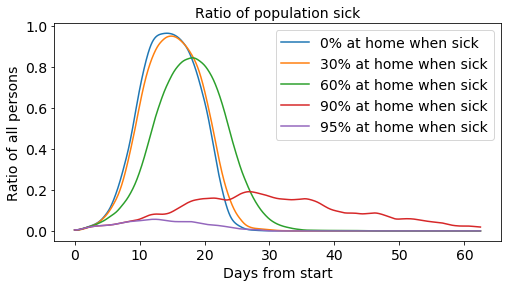

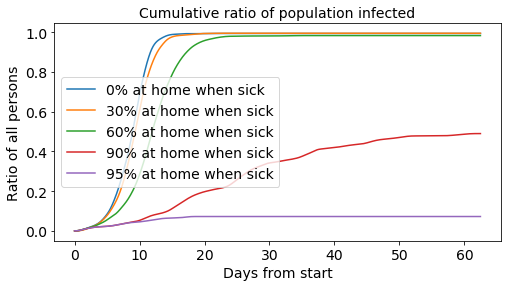

In [4]:
results = {}
for param in [0, 0.30, 0.6, 0.90, 0.95]:
    t0 = time.time()
    persons, events = setup_simulation(virus=virus, 
                                       vaccinated_ratio=0, 
                                       sick_leave_ok_ratio=param,
                                       n_sick=4)
    timestamps, sick_ratio = run_sim(persons=persons, 
                                     events=events,
                                     virus=virus,
                                     sim_hours=1500)
    t1 = time.time()
    print('Sim round took {:0.1f} s'.format(t1 - t0))
    results[param] = {}
    results[param]['x'] = timestamps
    results[param]['sick_ratio'] = sick_ratio 
    cumul_infs = cumul_inf_ratio(persons=persons, timestamps=timestamps)
    results[param]['cumul_new_inf'] = cumul_infs 
    results[param]['label'] = '{:0.0f}% at home when sick'.format(param * 100)
    
plot_sick_ratio(results)
plot_cumul_inf_ratio(results)

### Vaccination ratio effect on virus spreading 
- This tests that how the ratio of persons vaccinated will slow down the virus spreading.

Sim round took 13.7 s
Sim round took 13.8 s
Sim round took 7.4 s
Sim round took 6.6 s


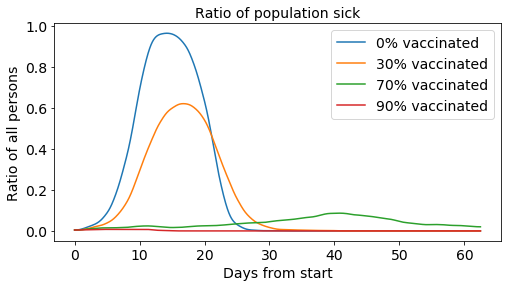

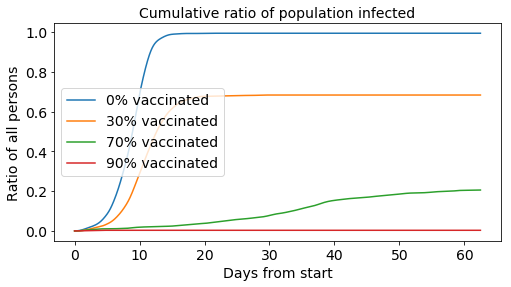

In [5]:
results = {}
for param in [0, 0.30, 0.7, 0.90]:
    t0 = time.time()
    persons, events = setup_simulation(virus=virus, 
                                       vaccinated_ratio=param, 
                                       sick_leave_ok_ratio=0,
                                       n_sick=4)
    timestamps, sick_ratio = run_sim(persons=persons, 
                                     events=events, 
                                     virus=virus,
                                     sim_hours=1500)
    t1 = time.time()
    print('Sim round took {:0.1f} s'.format(t1 - t0))
    results[param] = {}
    results[param]['x'] = timestamps
    results[param]['sick_ratio'] = sick_ratio 
    cumul_infs = cumul_inf_ratio(persons=persons, timestamps=timestamps)
    results[param]['cumul_new_inf'] = cumul_infs 
    results[param]['label'] = '{:0.0f}% vaccinated'.format(param * 100)
    
plot_sick_ratio(results)
plot_cumul_inf_ratio(results)

### Social distancing effect on virus spreading 
This tests that how increasing the number of schools (reducing the number of persons in each school) 

Sim round took 19.0 s
Sim round took 12.0 s
Sim round took 13.1 s
Sim round took 12.6 s
Sim round took 12.2 s


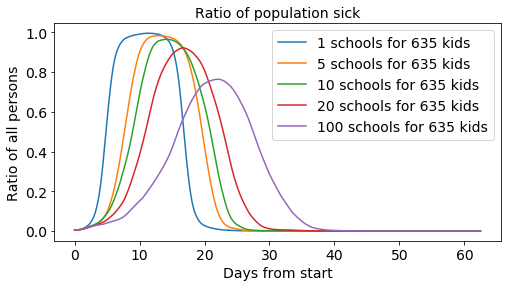

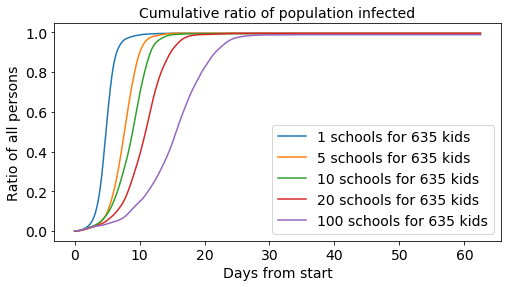

In [6]:
results = {}
for param in [1, 5, 10, 20, 100]:
    t0 = time.time()
    persons, events = setup_simulation(virus=virus, 
                                       n_school=param, 
                                       n_sick=4)
    # Calculate number of kids
    n_kid = 0
    for person in persons: 
        if person.state['age'] < 18: 
            n_kid += 1
            
    timestamps, sick_ratio = run_sim(persons=persons, 
                                     events=events, 
                                     virus=virus,
                                     sim_hours=1500)
    t1 = time.time()
    print('Sim round took {:0.1f} s'.format(t1 - t0))
    results[param] = {}
    results[param]['x'] = timestamps
    results[param]['sick_ratio'] = sick_ratio 
    cumul_infs = cumul_inf_ratio(persons=persons, timestamps=timestamps)
    results[param]['cumul_new_inf'] = cumul_infs 
    results[param]['label'] = '{} schools for {} kids'.format(param, n_kid)
    
plot_sick_ratio(results)
plot_cumul_inf_ratio(results)

### Combination of countermeasures
Compare the "do nothing" scenario to a heavy countermasures scenario

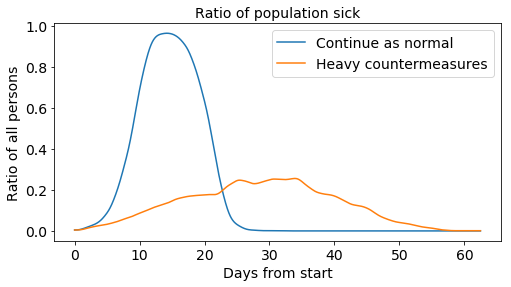

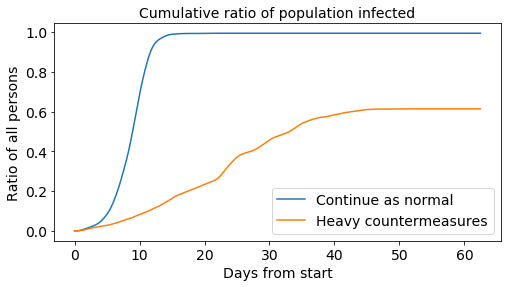

In [8]:
results = {}

# The "do nothing" scenario
param = 0
persons, events = setup_simulation(virus=virus, n_sick=4)
timestamps, sick_ratio = run_sim(persons=persons, 
                                 events=events, 
                                 virus=virus,
                                 sim_hours=1500)
results[param] = {}
results[param]['x'] = timestamps
results[param]['sick_ratio'] = sick_ratio 
cumul_infs = cumul_inf_ratio(persons=persons, timestamps=timestamps)
results[param]['cumul_new_inf'] = cumul_infs 
results[param]['label'] = 'Continue as normal'

# The heavy countermeasures scenario
# - Shut down schools 
# - Force 60% of sick to stay home
param = 1
persons, events = setup_simulation(virus=virus, 
                                   n_school=0,
                                   sick_leave_ok_ratio=0.6, 
                                   n_sick=4)
timestamps, sick_ratio = run_sim(persons=persons, 
                                 events=events, 
                                 virus=virus,
                                 sim_hours=1500)
results[param] = {}
results[param]['x'] = timestamps
results[param]['sick_ratio'] = sick_ratio 
cumul_infs = cumul_inf_ratio(persons=persons, timestamps=timestamps)
results[param]['cumul_new_inf'] = cumul_infs 
results[param]['label'] = 'Heavy countermeasures'

plot_sick_ratio(results)
plot_cumul_inf_ratio(results)